# Positive Predictive Value (PPV) Comparison Across Modalities

### Objective

Compare **PPV across all imaging modalities** to evaluate relative diagnostic accuracy.

### Data Source

- `side_concordance_results.xlsx` (pre-operative imaging and surgical outcomes)

### Outputs

| **Modality** | **PPV** |
|--------------|---------|
| SPECT/CT | 92.1% |
| 4D CT Scan | 85.4% |
| Ultrasound | 85.9% |
| Sestamibi | 99.1% |
| MRI | 75.0% |

---

In [10]:
import pandas as pd 
# preop_imaging_df = pd.read_excel('../../Data/side_concordance_results.xlsx')
preop_imaging_df = pd.read_excel('../../Data/final_imaging_data.xlsx')

In [11]:
modalities = ['SPECT/CT', '4D CT Scan', 'Ultrasound', 'Sestamibi', 'MRI']

def check_concordance(row, modality_col):
    imaging = row[modality_col]
    surgical = row['Surgical Findings']

    if pd.isnull(imaging) or pd.isnull(surgical):
        return 'Unknown'

    # Handle special cases
    if imaging == 'No Scan':
        return 'No Scan'
    if imaging == 'Non-localizing':
        return 'Non-localizing'
    if 'hyperplasia' in surgical.lower():
        return 'Incorrect Localization'

    imaging_glands = [g.strip().lower() for g in imaging.split(',')]
    surgical_glands = [g.strip().lower() for g in surgical.split(',')]
    imaging_set = set(imaging_glands)
    surgical_set = set(surgical_glands)

    if surgical_set.issubset(imaging_set):
        return 'Yes (Exact)'
    if imaging_set & surgical_set:
        return 'Yes (Partial)'

    imaging_sides = ['left' for ig in imaging_glands if 'left' in ig] + \
                    ['right' for ig in imaging_glands if 'right' in ig]
    surgical_sides = ['left' for sg in surgical_glands if 'left' in sg] + \
                     ['right' for sg in surgical_glands if 'right' in sg]

    if any(side in surgical_sides for side in imaging_sides):
        if len(surgical_glands) > 1:
            return 'Yes (Partial)'
        else:
            return 'Yes (Side)'
    return 'Incorrect Localization'


In [14]:

# Calculate PPV for each modality
ppv_dict = {}

for modality in modalities:
    concordance_col = modality + ' Calculated Concordance'
    
    # Calculate concordance for each modality using the function
    preop_imaging_df[concordance_col] = preop_imaging_df.apply(
        lambda row: check_concordance(row, modality),
        axis=1
    )
    
    # Filter localized scans (excluding No Scan and Non-localizing)
    localized_df = preop_imaging_df[
        ~preop_imaging_df[modality].isin(['No Scan', 'Non-localizing'])
    ].copy()
    
    # Calculate PPV components
    true_positive = localized_df[concordance_col].isin(['Yes (Exact)', 'Yes (Side)']).sum()
    false_positive = (localized_df[concordance_col] == 'Incorrect Localization').sum()
    
    ppv = round(true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else None, 2) * 100 
    ppv_dict[modality] = ppv

# Convert to DataFrame
ppv_df = pd.DataFrame(list(ppv_dict.items()), columns=['Modality', 'PPV (%)'])
display(ppv_df)

,Modality,PPV (%)
0,SPECT/CT,90.0
1,4D CT Scan,82.0
2,Ultrasound,84.0
3,Sestamibi,99.0
4,MRI,75.0


In [18]:
import matplotlib.pyplot as plt

# ppv_df['PPV (%)'] = ppv_df['PPV'].apply(lambda x: x * 100 if x is not None else None)

sorted_ppv_df = ppv_df.sort_values(by='PPV (%)', ascending=False)

# Define color palette 
colors = plt.cm.Set2(range(len(sorted_ppv_df)))

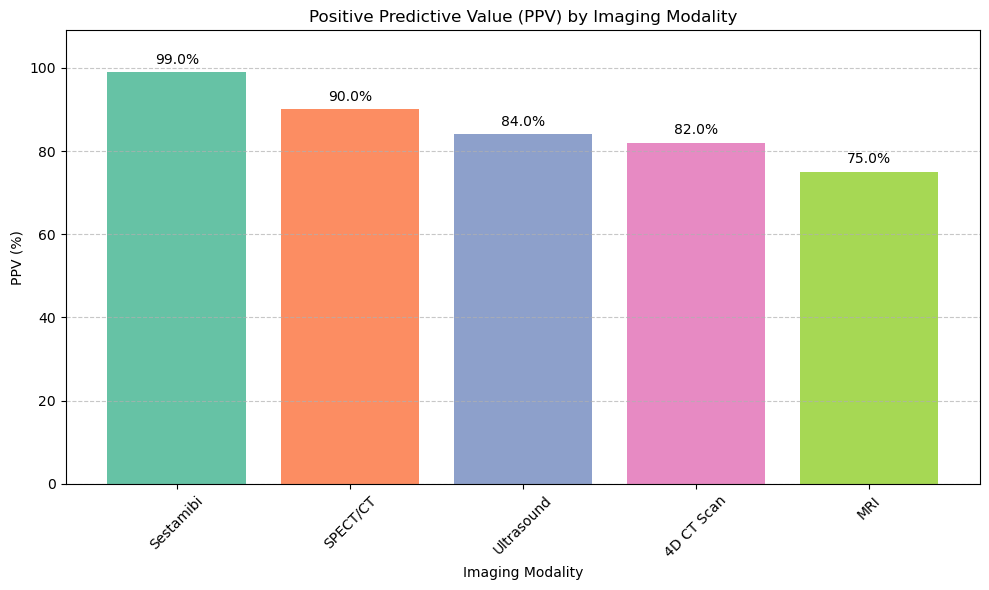

In [19]:
# Create figure and bar plot
plt.figure(figsize=(10,6))
plt.bar(sorted_ppv_df['Modality'], sorted_ppv_df['PPV (%)'], color=colors)

# Add grid lines for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels above each bar
for i, v in enumerate(sorted_ppv_df['PPV (%)']):
    plt.text(i, v + 2, f"{v:.1f}%", ha='center', fontsize=10)
    
plt.title('Positive Predictive Value (PPV) by Imaging Modality')
plt.ylabel('PPV (%)')
plt.xlabel('Imaging Modality')


# Adjust y-axis limits for breathing room
plt.ylim(0, sorted_ppv_df['PPV (%)'].max() + 10)


# Rotate x-axis labels for clarity
plt.xticks(rotation=45)

# Tight layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()
